In [ ]:
### WatchWise: RL-Based Personalized Movie Suggestions

# Step 1: Install Required Libraries
#!pip install gymnasium transformers pandas numpy scikit-learn torch

import pandas as pd
import numpy as np
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import pipeline
from sklearn.preprocessing import LabelEncoder
import pickle

In [ ]:
# Step 2: Load IMDb Dataset
from google.colab import drive
drive.mount('/content/drive')

# Check if preprocessed data exists
import os
if os.path.exists("/content/drive/MyDrive/processed_movies3.csv"):
    movies_df = pd.read_csv("/content/drive/MyDrive/processed_movies3.csv")
else:
    !wget -O title.basics.tsv.gz https://datasets.imdbws.com/title.basics.tsv.gz
    !wget -O title.ratings.tsv.gz https://datasets.imdbws.com/title.ratings.tsv.gz
    !gunzip title.basics.tsv.gz title.ratings.tsv.gz  # Unzip

    movies_df = pd.read_csv("title.basics.tsv", sep="\t", dtype=str, na_values="\\N")
    ratings_df = pd.read_csv("title.ratings.tsv", sep="\t", dtype=str, na_values="\\N")

    # Filter movies and merge with ratings
    movies_df = movies_df[movies_df["titleType"] == "movie"][["tconst", "primaryTitle", "startYear", "genres"]]
    ratings_df = ratings_df[["tconst", "averageRating"]]
    movies_df = movies_df.merge(ratings_df, on="tconst")

    # Convert ratings to float and filter movies with rating >= 7.0
    movies_df["averageRating"] = movies_df["averageRating"].astype(float)
    movies_df = movies_df[(movies_df["averageRating"] >= 7.0) & (movies_df["startYear"].astype(float) > 1999)]
    #movies_df = movies_df[movies_df["startYear"].astype(int) > 2000]

    # Encode movie titles as numerical indices
    label_encoder = LabelEncoder()
    movies_df["movie_encoded"] = label_encoder.fit_transform(movies_df["primaryTitle"])

    # Save preprocessed data
    movies_df.to_csv("/content/drive/MyDrive/processed_movies3.csv", index=False)
    pickle.dump(label_encoder, open("/content/drive/MyDrive/encoder_label3.pkl", "wb"))

movies_df.head()

Mounted at /content/drive


,tconst,primaryTitle,startYear,genres,averageRating,movie_encoded
0,tt0070596,Socialist Realism,2023,"Drama,History",7.0,46857
1,tt0097304,Everything's for You,2009,Documentary,7.0,17200
2,tt0097767,Loading Ludwig,2022,NaN,7.0,30593
3,tt0104988,Neues in Wittstock,2021,Documentary,7.8,36164
4,tt0108549,West from North Goes South,2004,"Comedy,Mystery",7.9,61842


In [ ]:
# Define moods and constants
moods = ["happy", "sad", "calm","excited","lonely","stressed","bored","angry","nostalgic","anxious","motivated","curious"]

# Safely extract all unique genres (replace movies_df with your actual data)
all_genres = sorted(set(
    g.strip() for genre_str in movies_df['genres'].dropna()
    for g in str(genre_str).split(',')
))
print(all_genres)

['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']


In [ ]:
# Step 4: Sentiment Analysis for Chatbot
sentiment_analyzer = pipeline("sentiment-analysis")

def analyze_mood(user_input):
    sentiment = sentiment_analyzer(user_input)[0]
    label = sentiment["label"].lower()

    if label == "positive":
        detected_mood = "happy"
    elif label == "negative":
        detected_mood = "sad"
    else:
        detected_mood = "calm"

    # Keyword-based mood detection
    # mood_keywords = {
    #     "excited": ["excited", "thrilled", "energetic", "pumped"],
    #     "lonely": ["lonely", "alone", "isolated"],
    #     "stressed": ["stressed", "overwhelmed", "anxious"],
    #     "bored": ["bored", "nothing to do", "dull"],
    #     "angry": ["angry", "frustrated", "mad"],
    #     "calm": ["calm", "peaceful", "relaxed"],
    #     "exit": ["exit", "quit", "bye"]
    # }
    # Enhanced Keyword-based Mood Detection
    mood_keywords = {
        "calm": ["calm", "peaceful", "relaxed", "serene", "tranquil", "at ease"],
        "excited": ["excited", "thrilled", "energetic", "pumped", "ecstatic", "hyped"],
        "lonely": ["lonely", "alone", "isolated", "abandoned", "forgotten"],
        "stressed": ["stressed", "overwhelmed", "anxious", "tense", "worried", "burnt out"],
        "bored": ["bored", "nothing to do", "dull", "uninterested", "tired", "meh"],
        "angry": ["angry", "frustrated", "mad", "furious", "annoyed", "irritated"],
        "nostalgic": ["nostalgic", "sentimental", "missing the past", "childhood", "old times"],
        "anxious": ["anxious", "nervous", "worried", "panicked", "on edge"],
        "motivated": ["motivated", "inspired", "driven", "goal-oriented", "focused", "determined"],
        "curious": ["curious", "interested", "inquisitive", "eager to learn", "wondering"],
        "exit": ["exit", "quit", "bye", "goodbye", "see you", "leave"]
    }


    for mood, keywords in mood_keywords.items():
        if any(word in user_input.lower() for word in keywords):
            detected_mood = mood
            break

    return detected_mood

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
user_text = "i have headache"
user_mood = analyze_mood(user_text)
print(f"Detected Mood: {user_mood}")

Detected Mood: sad


Evaluating for synthetic user: User1


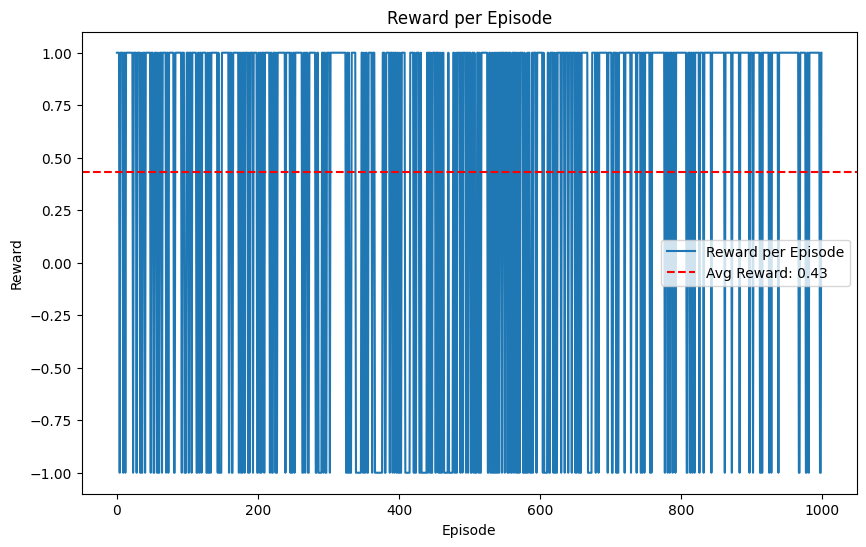

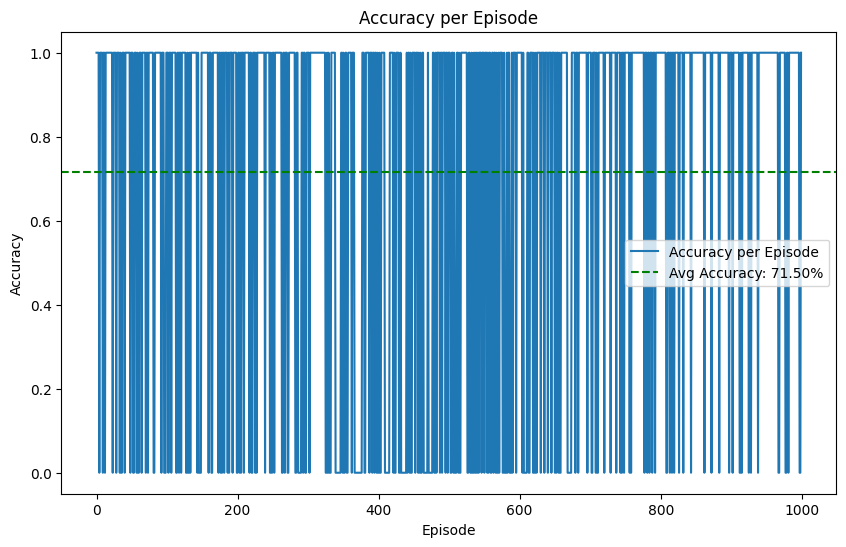

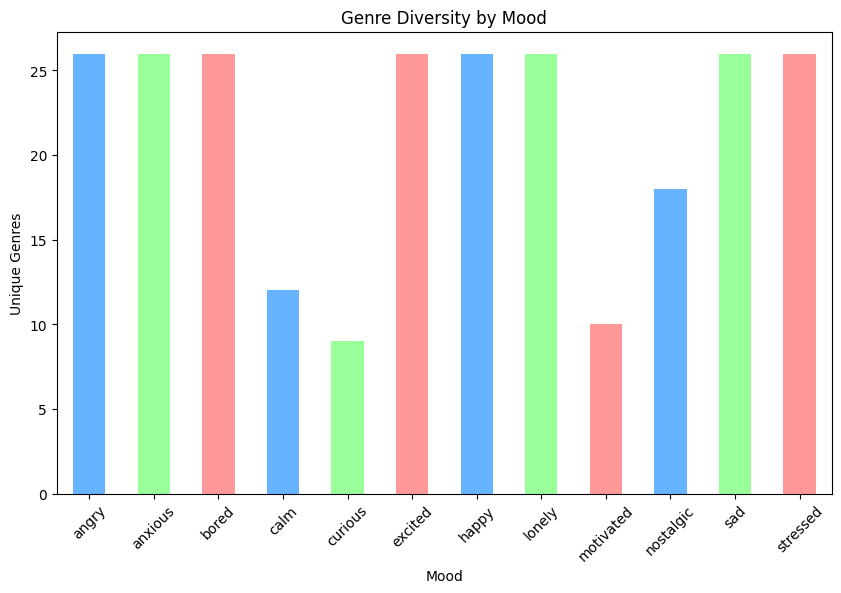

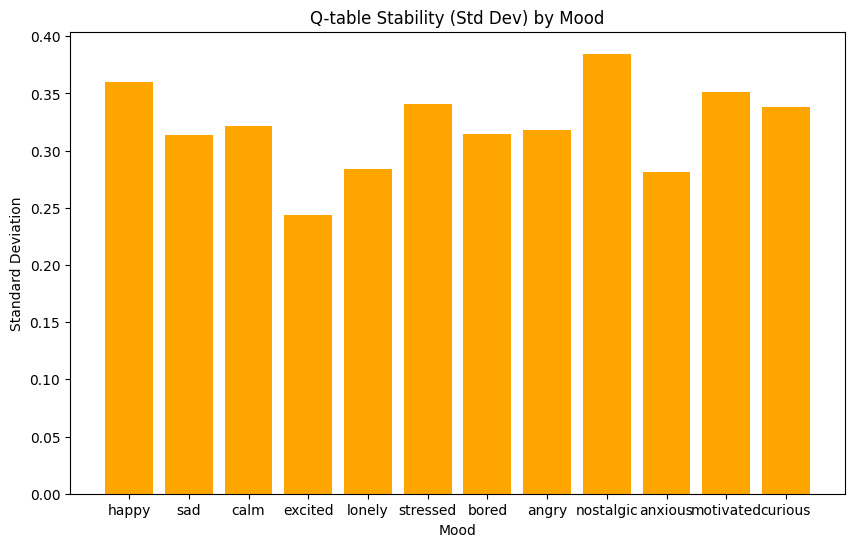

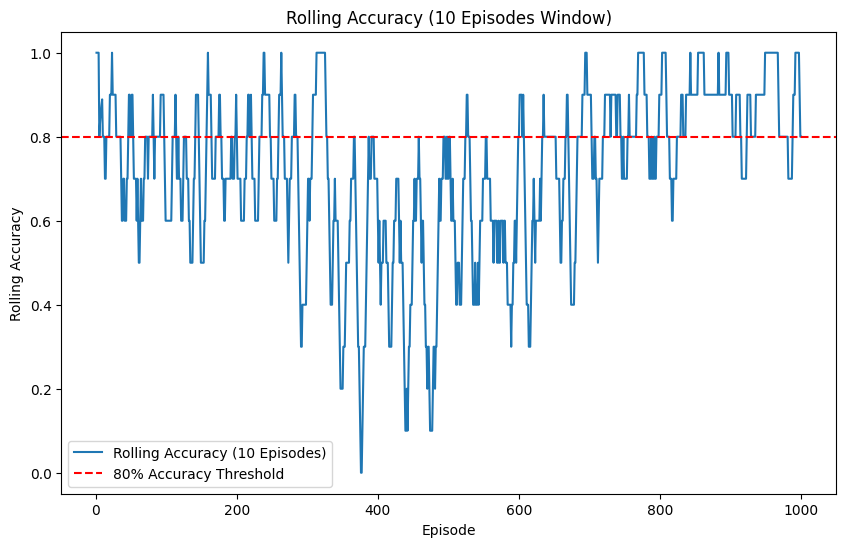


🔢 Average Reward: 0.43
✅ Accuracy: 71.50%
🎯 Genre Diversity by Mood:
 mood
angry        26
anxious      26
bored        26
calm         12
curious       9
excited      26
happy        26
lonely       26
motivated    10
nostalgic    18
sad          26
stressed     26
Name: genre, dtype: int64
📉 Q-table Stability (Std Dev) by Mood:
 {'happy': np.float64(0.36005852924238424), 'sad': np.float64(0.31383370533719807), 'calm': np.float64(0.3213322857570065), 'excited': np.float64(0.24375732793730295), 'lonely': np.float64(0.2836106266269244), 'stressed': np.float64(0.3409610224101056), 'bored': np.float64(0.31485197439318763), 'angry': np.float64(0.31766467497388173), 'nostalgic': np.float64(0.3847280258313789), 'anxious': np.float64(0.28169466820420025), 'motivated': np.float64(0.35111956398558436), 'curious': np.float64(0.3378479191922461)}
⏱️ Adaptation Episode (80% accuracy): 0


In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# Define moods and constants
# moods = ["happy", "sad", "calm","excited","lonely","stressed","bored","angry"]
num_episodes = 1000
epsilon = 0.1
alpha = 0.5
gamma = 0.9

# Sample synthetic user (replace with your actual synthetic_users list)
synthetic_users = [{
    'name': 'User1',
    'preferences': {
        'happy': ['Comedy', 'Adventure'],
        'sad': ['Drama', 'Romance'],
        'calm': ['Documentary', 'Fantasy'],
        'bored': ['Action', 'Thriller'],
        'angry': ['Horror', 'Mystery'],
        'excited': ['Animation', 'Sci-Fi'],
        'lonely': ['Crime', 'Western'],
        'stressed': ['Biography', 'History'],
        'nostalgic': ['Musical', 'Family'],
        'anxious': ['War', 'Film-Noir'],
        'motivated': ['Sport', 'Action'],
        'curious': ['Documentary', 'Sci-Fi']
    },
    'accept_prob': 0.96
}]


genre_to_idx = {g: i for i, g in enumerate(all_genres)}
idx_to_genre = {i: g for g, i in genre_to_idx.items()}

# Initialize Q-table
Q = np.zeros((len(moods), len(all_genres)))

for mood in moods:
    mood_idx = moods.index(mood)
    for genre in all_genres:
        genre_idx = genre_to_idx[genre]
        if genre in default_preferences.get(mood, []):
            Q[mood_idx][genre_idx] = 0.1


# Tracking lists
reward_log = []
accuracy_log = []
genre_log = []
rolling_accuracy_log = []

# Pick a user
user = random.choice(synthetic_users)
print(f"Evaluating for synthetic user: {user['name']}")

# Training loop
for episode in range(num_episodes):
    mood_idx = random.randint(0, len(moods) - 1)
    mood = moods[mood_idx]

    # Epsilon-greedy action selection
    if random.random() < epsilon:
        genre_idx = random.randint(0, len(all_genres) - 1)
    else:
        genre_idx = np.argmax(Q[mood_idx])
    genre = idx_to_genre[genre_idx]

    # Simulate feedback
    preferred = genre in user['preferences'][mood]
    accepted = random.random() < user['accept_prob'] if preferred else random.random() < 0.2
    reward = 1 if accepted else -1

    # Q-learning update
    Q[mood_idx][genre_idx] += alpha * (reward + gamma * 0 - Q[mood_idx][genre_idx])

    # Logging
    reward_log.append(reward)
    accuracy_log.append(1 if accepted else 0)
    genre_log.append((mood, genre))

    # Rolling accuracy for adaptation tracking
    rolling_accuracy_log.append(np.mean(accuracy_log[-10:]))

# Metrics Calculation
avg_reward = np.mean(reward_log)
df_genre = pd.DataFrame(genre_log, columns=["mood", "genre"])
genre_diversity = df_genre.groupby("mood")["genre"].nunique()
accuracy = np.mean(accuracy_log)
q_stability = {mood: np.std(Q[i]) for i, mood in enumerate(moods)}
adaptation_ep = next((i for i, x in enumerate(rolling_accuracy_log) if x > 0.8), -1)

# Plot Results

# 1. Average Reward
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_episodes), reward_log, label="Reward per Episode")
plt.axhline(y=avg_reward, color='r', linestyle='--', label=f"Avg Reward: {avg_reward:.2f}")
plt.title("Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

# 2. Accuracy (Acceptance Rate)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_episodes), accuracy_log, label="Accuracy per Episode")
plt.axhline(y=accuracy, color='g', linestyle='--', label=f"Avg Accuracy: {accuracy*100:.2f}%")
plt.title("Accuracy per Episode")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 3. Genre Diversity by Mood
plt.figure(figsize=(10, 6))
genre_diversity.plot(kind='bar', color=['#66b3ff', '#99ff99', '#ff9999'])
plt.title("Genre Diversity by Mood")
plt.ylabel("Unique Genres")
plt.xlabel("Mood")
plt.xticks(rotation=45)
plt.show()

# 4. Q-table Stability (Std Dev)
plt.figure(figsize=(10, 6))
plt.bar(moods, [np.std(Q[i]) for i in range(len(moods))], color='orange')
plt.title("Q-table Stability (Std Dev) by Mood")
plt.ylabel("Standard Deviation")
plt.xlabel("Mood")
plt.show()

# 5. Adaptation Episode (80% accuracy)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(rolling_accuracy_log) + 1), rolling_accuracy_log, label="Rolling Accuracy (10 Episodes)")
plt.axhline(y=0.8, color='r', linestyle='--', label="80% Accuracy Threshold")
plt.title("Rolling Accuracy (10 Episodes Window)")
plt.xlabel("Episode")
plt.ylabel("Rolling Accuracy")
plt.legend()
plt.show()

# Results summary
print(f"\n🔢 Average Reward: {avg_reward:.2f}")
print(f"✅ Accuracy: {accuracy*100:.2f}%")
print("🎯 Genre Diversity by Mood:\n", genre_diversity)
print("📉 Q-table Stability (Std Dev) by Mood:\n", q_stability)
print(f"⏱️ Adaptation Episode (80% accuracy): {adaptation_ep}")

In [ ]:
q_table_df = pd.DataFrame(Q, index=moods, columns=all_genres)
print("\n🎯 Learned Q-table:")
#print(q_table_df.round(2))
q_table_df


🎯 Learned Q-table:


,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
happy,-5.000000e-01,-0.500,0.96875,-0.450,-0.50000,-0.003906,-0.5,-5.000000e-01,-0.25,-0.250000,...,-0.25,-0.50000,-0.500,-0.500,-0.250000,-0.500000,-0.5000,-0.25,-0.500000,-0.25
sad,-5.000000e-01,-0.500,-0.50000,-0.250,-0.50000,-0.500000,-0.5,-5.000000e-01,1.00,-0.250000,...,-0.25,-0.50000,-0.500,-0.225,-0.500000,-0.500000,-0.5000,-0.50,-0.500000,-0.50
calm,0.000000e+00,0.000,-0.50000,0.000,-0.03125,0.000000,0.0,-1.637024e-12,-0.25,-0.750000,...,0.00,0.00000,0.000,-0.500,0.000000,0.000000,0.0000,0.00,0.000000,-0.50
excited,-4.500000e-01,0.000,0.00000,0.000,0.00000,0.000000,0.0,0.000000e+00,0.00,0.000000,...,-0.50,0.00000,-0.875,0.000,1.000000,-0.500000,0.0000,-0.45,0.000000,0.00
lonely,0.000000e+00,-0.500,0.00000,0.000,-0.75000,-0.500000,1.0,0.000000e+00,0.00,-0.500000,...,0.00,0.00000,0.000,0.000,0.000000,0.500000,0.0000,-0.50,0.000000,0.10
stressed,-2.500000e-01,-0.500,-0.62500,-0.500,-0.22500,-0.500000,-0.5,-5.000000e-01,-0.25,-0.375000,...,-0.50,-0.50000,-0.500,-0.500,-0.250000,-0.250000,-0.5000,-0.50,-0.500000,-0.75
bored,-2.095476e-10,0.000,0.25000,0.000,0.00000,0.000000,0.0,-2.500000e-01,0.00,0.000000,...,-0.45,0.00000,0.000,0.000,0.000000,-0.500000,0.0000,1.00,-0.500000,0.00
angry,-2.812500e-01,-0.500,-0.50000,-0.500,-0.50000,-0.500000,-0.5,0.000000e+00,0.00,-0.500000,...,0.00,-0.50000,0.000,-0.500,0.000000,0.000000,0.0000,0.00,0.000000,-0.50
nostalgic,-2.500000e-01,-0.250,-0.25000,-0.725,-0.50000,-0.375000,-0.5,-5.000000e-01,-0.50,-0.000061,...,-0.50,-0.50000,-0.500,-0.725,-0.500000,0.250000,-0.6875,-0.50,-0.250000,-0.50
anxious,-7.500000e-01,-0.625,-0.62500,-0.500,-0.31250,-0.500000,-0.5,-5.000000e-01,-0.45,-0.500000,...,-0.50,-0.78125,-0.500,-0.500,-0.578125,-0.750000,-0.5000,-0.50,0.990234,-0.50


In [ ]:
# === STEP 1: Build genre success history from RL logs ===
from collections import Counter

genre_success_counter = Counter()

for (mood, genre), accepted in zip(genre_log, accuracy_log):
    if accepted:
        genre_success_counter[genre] += 1

# Get most accepted genres sorted
most_liked_genres = [genre for genre, _ in genre_success_counter.most_common()]

# === STEP 2: Static model uses the top genre always, regardless of mood ===
static_accuracy_log = []

for episode in range(num_episodes):
    mood_idx = random.randint(0, len(moods) - 1)
    mood = moods[mood_idx]

    if most_liked_genres:
        static_genre = most_liked_genres[0]  # Top liked genre
    else:
        static_genre = random.choice(all_genres)  # Fallback if no success data

    preferred = static_genre in user['preferences'][mood]
    accepted = random.random() < user['accept_prob'] if preferred else random.random() < 0.2

    static_accuracy_log.append(1 if accepted else 0)

# === STEP 3: Compare ===
static_accuracy = np.mean(static_accuracy_log)
rl_accuracy = np.mean(accuracy_log)
percent_improvement = ((rl_accuracy - static_accuracy) / static_accuracy) * 100 if static_accuracy > 0 else 0

# === STEP 4: Print ===
print("\n📊 Static Model Accuracy (Top-Liked Genre): {:.2f}%".format(static_accuracy * 100))
print("🤖 RL Model Accuracy: {:.2f}%".format(rl_accuracy * 100))
print("🚀 Satisfaction Improvement from RL: {:.2f}%".format(percent_improvement))


📊 Static Model Accuracy (Top-Liked Genre): 33.00%
🤖 RL Model Accuracy: 71.50%
🚀 Satisfaction Improvement from RL: 116.67%


In [ ]:
# Define assumed preferred genres per mood
default_preferences = {
    'happy': ['Comedy', 'Adventure', 'Animation'],
    'sad': ['Drama', 'Romance'],
    'calm': ['Documentary', 'Fantasy'],
    'excited': ['Action', 'Sci-Fi', 'Thriller'],
    'lonely': ['Crime', 'Western'],
    'stressed': ['Biography', 'History'],
    'bored': ['Action', 'Thriller', 'Mystery'],
    'angry': ['Horror', 'Mystery'],
    'nostalgic': ['Romance', 'Animation'],
    'anxious': ['Drama', 'Fantasy'],
    'motivated': ['Biography', 'Sport'],
    'curious': ['Documentary', 'Mystery', 'Sci-Fi']
}

In [ ]:
import random

#Q = {mood: {genre: 0 for genre in all_genres} for mood in moods}

# Initialize Q-table with warm start
Q = {
    mood: {
        genre: (0.1 if genre in default_preferences.get(mood, []) else 0)
        for genre in all_genres
    }
    for mood in moods
}

# Parameters
alpha = 0.1     # learning rate
gamma = 0.9     # discount factor
epsilon = 0.1   # exploration rate

def get_best_genre(q_values):
    """Choose best genre with epsilon-greedy exploration"""
    if random.random() < epsilon:
        return random.choice(list(q_values.keys()))  # explore
    else:
        return max(q_values, key=q_values.get)       # exploit

def get_random_movie(df, genre):
    """Get a random movie from the given genre"""
    filtered = df[df['genres'] == genre]
    if not filtered.empty:
        return filtered.sample(1).iloc[0]
    else:
        return None

def get_random_movies(df, genre, k=10):
    genre_movies = df[df['genres'].str.contains(genre, na=False)]
    if genre_movies.empty:
        return []
    return genre_movies.sample(min(len(genre_movies), k)).to_dict(orient='records')


print("🎬 Welcome to WatchWise Interactive Movie Recommender!")
print("Type 'exit' anytime to quit.\n")

while True:
    # 1. Ask for mood
    mood = analyze_mood(input("🧠 Enter your mood (happy/sad/calm/excited/lonely/stressed/bored/angry/nostalgic/anxious/motivated/curious): ").strip().lower())
    if mood == 'exit':
        break
    if mood not in Q:
        print("❌ Unknown mood. Please try again.")
        continue

    # 2. Choose genre using Q-table
    genre = get_best_genre(Q[mood])

    # # 3. Recommend a movie from that genre
    # movie = get_random_movie(movies_df, genre)
    # if movie is None:
    #     print(f"No movies found in genre '{genre}'.")
    #     continue

    # print(f"\n🎥 Recommended Movie for '{mood}' mood:")
    # print(f"Title: {movie['primaryTitle']}  |  Genre: {movie['genres']}")

    # 3. Recommend 10 movies from that genre
    movies = get_random_movies(movies_df, genre, k=2)
    if not movies:
        print(f"No movies found in genre '{genre}'.")
        continue

    print(f"\n🎥 Recommended Movies for '{mood}' mood and genre '{genre}':")
    for i, movie in enumerate(movies, 1):
        print(f"{i}. Title: {movie['primaryTitle']}  |  Genre: {movie['genres']}")


    # 4. Get feedback
    feedback = input("Did you like this recommendation? (👍/👎): ").strip()
    reward = 1 if feedback == '1' else -1

    # 5. Update Q-table
    old_q = Q[mood][genre]
    Q[mood][genre] = old_q + alpha * (reward + gamma * max(Q[mood].values()) - old_q)

    print("✅ Feedback noted. Q-table updated.\n")


🎬 Welcome to WatchWise Interactive Movie Recommender!
Type 'exit' anytime to quit.

🧠 Enter your mood (happy/sad/calm/excited/lonely/stressed/bored/angry/nostalgic/anxious/motivated/curious): nostalgic

🎥 Recommended Movies for 'nostalgic' mood and genre 'Animation':
1. Title: Pandi  |  Genre: Animation,Biography,Documentary
2. Title: Pui Pui Molcar the Movie: Molmax  |  Genre: Adventure,Animation,Comedy
Did you like this recommendation? (👍/👎): 0
✅ Feedback noted. Q-table updated.

🧠 Enter your mood (happy/sad/calm/excited/lonely/stressed/bored/angry/nostalgic/anxious/motivated/curious): nostalgic

🎥 Recommended Movies for 'nostalgic' mood and genre 'Romance':
1. Title: Half Girlfriend 2  |  Genre: Romance
2. Title: Bab el shams  |  Genre: Drama,Romance,War
Did you like this recommendation? (👍/👎): 0
✅ Feedback noted. Q-table updated.

🧠 Enter your mood (happy/sad/calm/excited/lonely/stressed/bored/angry/nostalgic/anxious/motivated/curious): nostalgic

🎥 Recommended Movies for 'nostalgi

In [ ]:
import random
from collections import Counter

# Initialize genre acceptance counter
genre_acceptance_counter = Counter()

print("🎬 Welcome to Static Movie Recommender (Non-mood based)!")
print("Type 'exit' anytime to quit.\n")

while True:
    # Ask user for mood (just for message clarity — not used in decision)
    mood = input("🧠 Enter your mood (happy/sad/calm/excited/lonely/stressed/bored/angry/nostalgic/anxious/motivated/curious): ").strip().lower()
    if mood == 'exit':
        break

    # Recommend based on most liked genre so far (fallback to random if none yet)
    if genre_acceptance_counter:
        genre = genre_acceptance_counter.most_common(1)[0][0]
    else:
        genre = random.choice(all_genres)

    # Recommend multiple movies from the genre
    movies = get_random_movies(movies_df, genre, k=2)
    if not movies:
        print(f"No movies found in genre '{genre}'.")
        continue

    print(f"\n🎥 Recommended Movies (based on general popularity):")
    for i, movie in enumerate(movies, 1):
        print(f"{i}. Title: {movie['primaryTitle']}  |  Genre: {movie['genres']}")

    # Ask for feedback
    feedback = input("Did you like this recommendation? (👍/👎): ").strip()
    if feedback == '1':
        genre_acceptance_counter[genre] += 1  # Increase count for accepted genre
        print("✅ Feedback noted. Thanks!\n")
    else:
        print("❌ Sorry about that. We’ll try better!\n")

🎬 Welcome to Static Movie Recommender (Non-mood based)!
Type 'exit' anytime to quit.

🧠 Enter your mood (happy/sad/calm/excited/lonely/stressed/bored/angry/nostalgic/anxious/motivated/curious): happy

🎥 Recommended Movies (based on general popularity):
1. Title: It Happened Here  |  Genre: Crime,Documentary,Drama
2. Title: Ek Nadir Galpo  |  Genre: Drama
Did you like this recommendation? (👍/👎): 0
❌ Sorry about that. We’ll try better!

🧠 Enter your mood (happy/sad/calm/excited/lonely/stressed/bored/angry/nostalgic/anxious/motivated/curious): happy

🎥 Recommended Movies (based on general popularity):
1. Title: Jack Stone: Rogue Albion  |  Genre: Action,Thriller
2. Title: Heinrich der Säger  |  Genre: Action,Adventure,Comedy
Did you like this recommendation? (👍/👎): 1
✅ Feedback noted. Thanks!

🧠 Enter your mood (happy/sad/calm/excited/lonely/stressed/bored/angry/nostalgic/anxious/motivated/curious): sad

🎥 Recommended Movies (based on general popularity):
1. Title: Jewel Fools  |  Genre: 